<a href="https://colab.research.google.com/github/CeesGniewyk/Food-Classification/blob/master/Efficientnet/Food_Classifications_Efficientnet_B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

After loading the VGG16 onto the raspberry Pi, the time that it took the model to make a picture and infer the class took almost up to 5 seconds. For our use-case this would be too slow. <br> 
In this notebook we will be trying out different architectures, there have been multiple improvements made on lightweight computer vision models that we will explore in this notebook. <br>

# Google Drive & Git

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!git clone https://github.com/CeesGniewyk/Food-Classification

Cloning into 'Food-Classification'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 67 (delta 6), reused 19 (delta 1), pack-reused 27
Unpacking objects: 100% (67/67), done.


# Packages

In [0]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model, load_model, save_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, Reshape, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, History

def plotplease():
  import IPython
  from plotly.offline import init_notebook_mode
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
  '''))
  init_notebook_mode(connected=False)

import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# Pickle for storing files
import pickle
def load_file(file_name):
    f = open(file_name, 'rb')
    read_file = pickle.load(f)
    print("file loaded")
    f.close()
    return read_file

def save_file(file_name, data):
    f = open(file_name, 'wb')
    pickle.dump(data, f, protocol=4)
    print(" file saved")
    f.close()

%cd /content/drive/My Drive/Project Support List/Practical Edge Computing/Data/food11

/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


/content/drive/My Drive/Project Support List/Practical Edge Computing/Data/food11


# Checking size of VGG16-based model

The time it takes the model to do inference is linearly correlated with the size of the model, measured in model parameters. <br>
We will load the VGG16-based model to see the amount of parameters. <br>


In [0]:
VGG16Model = load_model("/content/drive/My Drive/Project Support List/Practical Edge Computing/Data/food11/VGG16 Model/bestmodel.hdf5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
VGG16Model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               51300     
_________________________________________________________________
dense_2 (Dense)              (None, 11)                1111      
Total params: 14,767,099
Trainable params: 14,767,099
Non-trainable params: 0
_________________________________________________________________


Using the .summary() command we can see that the amount of parameters is 14,767,099. <br>
In the following picture you can see a graph that displays different models according to their imagenet accuracy vs number of parameters. <br>
![Efficientnet Picture](https://pythonawesome.com/content/images/2019/06/params.png) <br>
We will be using this image as inspiration for choosing a new model. <br>
According to the number of parameters, most of these models will lie on the right side of the VGG-16 model, but some are smaller. <br>
We will be comparing the performance of the B3 and the B0 model and comparing these with their total amount of parameters. <br> 
We expect the B0 model to perform much worse than the B3 model, but with using less parameters.


# Load Data
The preprocessing is almost exactly similar to the pre-processing as done in the VGG-16 model, however the color spectrum has to be scaled between -1 and 1 whereas this was between 0 and 1 for the VGG-16 model. <br>
This will be done in the following section.

In [0]:
train = [os.path.join("training",img) for img in os.listdir("training")]
val = [os.path.join("validation",img) for img in os.listdir("validation")]
test = [os.path.join("evaluation",img) for img in os.listdir("evaluation")]
print(len(train), len(val),len(test))

9866 3430 3347


# Pre Process

In [0]:
train_y = [int(img.split("/")[-1].split("_")[0]) for img in train]
val_y = [int(img.split("/")[-1].split("_")[0]) for img in val]
test_y = [int(img.split("/")[-1].split("_")[0]) for img in test]
num_classes = 11
y_train = utils.to_categorical(train_y, num_classes)
y_val = utils.to_categorical(val_y, num_classes)
y_test = utils.to_categorical(test_y, num_classes)

Training data available in 11 classes
[994, 429, 1500, 986, 848, 1325, 440, 280, 855, 1500, 709]


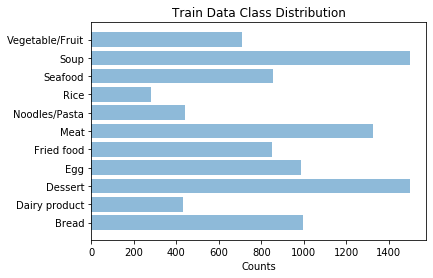

Validation data available in 11 classes
[362, 144, 500, 327, 326, 449, 147, 96, 347, 500, 232]
Test data available in 11 classes
[368, 148, 500, 335, 287, 432, 147, 96, 303, 500, 231]


In [0]:
print("Training data available in 11 classes")
print([train_y.count(i) for i in range(0,11)])

food_classes = ('Bread','Dairy product','Dessert','Egg','Fried food','Meat',
           'Noodles/Pasta','Rice','Seafood', 'Soup', 'Vegetable/Fruit')
categories = ['Bread','Dairy product','Dessert','Egg','Fried food','Meat',
           'Noodles/Pasta','Rice','Seafood', 'Soup', 'Vegetable/Fruit']
y_pos = np.arange(len(food_classes))
counts = [train_y.count(i) for i in range(0,11)]

plt.barh(y_pos, counts, align='center', alpha=0.5)
plt.yticks(y_pos, food_classes)
plt.xlabel('Counts')
plt.title('Train Data Class Distribution')

plt.show()

print("Validation data available in 11 classes")
print([val_y.count(i) for i in range(0,11)])
print("Test data available in 11 classes")
print([test_y.count(i) for i in range(0,11)])

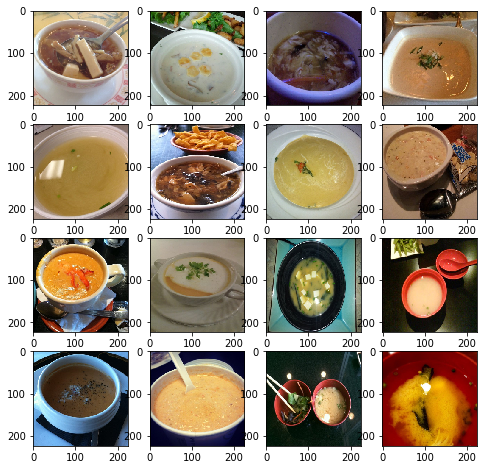

In [0]:
def show_imgs(X):
    plt.figure(figsize=(8, 8))
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            image = load_img(train[k], target_size=(224, 224))
            plt.subplot2grid((4,4),(i,j))
            plt.imshow(image)
            k = k+1
    plt.show()
show_imgs(train)

## Feature Extraction
Custom function to extract features of each image in Food-11 dataset. <br>
This function deviates from the one at the VGG-16 Model due to the fact that here we are simply taking the image and dividing the value by 255. to scale it between -1 and 1.

In [0]:
def create_features(dataset):
    x_scratch = []
    # loop over the images
    for imagePath in tqdm(dataset):
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)
        image = image/255
        image = np.expand_dims(image, axis=0)  
        x_scratch.append(image)    
    x = np.vstack(x_scratch)
    return x

The feature being extracted for each dataset train, val and test is preprocessed raw input image (224,224,3). <br>
This only has to be done once

In [0]:
# # Don't run in one go, not enough RAM
# train_x = create_features(train)
# val_x = create_features(val)
# test_x = create_features(test)

In [0]:
# # Don't run in one go, not enough RAM
# save_file("Efficientnet Model/training_data.p",train_x)
# save_file("Efficientnet Model/validation_data.p",val_x)
# save_file("Efficientnet Model/testing_data.p",test_x)

# Modelling
The code for the two models only differ on the model that is imported. <br>
In the next sections we will create the two models and train them on the food-11 dataset.

## Loading Saved Features

In [0]:
%cd /content/drive/My Drive/Project Support List/Practical Edge Computing/Data/food11/
train_x = load_file("Efficientnet B3 Model/training_data.p")
test_x = load_file("Efficientnet B3 Model/testing_data.p")
val_x = load_file("Efficientnet B3 Model/validation_data.p")

/content/drive/My Drive/Project Support List/Practical Edge Computing/Data/food11
file loaded
file loaded
file loaded


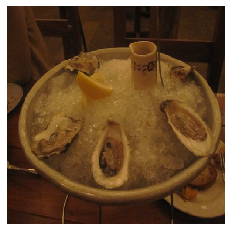

Class is: Seafood


In [0]:
#@title Show Training Set {run:"auto"}
example_id = 1014 #@param {type:"slider", min:0, max:9865, step:1}
label = train_y[example_id]
plt.imshow(train_x[example_id])
plt.axis("off")
plt.show()
print("Class is: {}".format(categories[label]))

## Fine Tuning EfficientNetB3

In [0]:
%cd /content
!git clone https://github.com/Tony607/efficientnet_keras_transfer_learning
%cd /content/efficientnet_keras_transfer_learning/
from efficientnet import EfficientNetB3 as Net
model_baseB3 = Net(weights="imagenet", include_top=False, input_shape=train_x.shape[1:])
%cd /content/drive/My Drive/Project Support List/Practical Edge Computing/Data/food11/
model_baseB3.summary()

/content
fatal: destination path 'efficientnet_keras_transfer_learning' already exists and is not an empty directory.
/content/efficientnet_keras_transfer_learning
43974656/43966704 [==============================] - 4s 0us/step
/content/drive/My Drive/Project Support List/Practical Edge Computing/Data/food11
Model: "efficientnet-b3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_65 (Conv2D)              (None, 112, 112, 40) 1080        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, 112, 112, 40) 160         conv2

### Building Model

In [0]:
model_effinetB3 = Sequential()
model_effinetB3.add(model_baseB3)
model_effinetB3.add(GlobalAveragePooling2D())
model_effinetB3.add(Dropout(0.35))
model_effinetB3.add(Dense(100, activation='relu'))
model_effinetB3.add(Dense(11, activation='softmax'))
model_effinetB3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Model)      (None, 7, 7, 1536)        10783528  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               153700    
_________________________________________________________________
dense_1 (Dense)              (None, 11)                1111      
Total params: 10,938,339
Trainable params: 10,851,043
Non-trainable params: 87,296
_________________________________________________________________


In [0]:
epochs = 50
patiencev = 7
cbs = [EarlyStopping(monitor='val_loss', patience=patiencev, verbose=1, mode='min')]
opt = Adam(lr=0.00001)
model_effinetB3.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
history = model_effinetB3.fit(train_x, y_train, batch_size=32, epochs=epochs,
          validation_data=(val_x, y_val), callbacks=cbs,verbose=1, shuffle=True)

Train on 9866 samples, validate on 3430 samples
Epoch 1/50
9866/9866 [==============================] - 150s 15ms/sample - loss: 1.8333 - acc: 0.4496 - val_loss: 1.6998 - val_acc: 0.5487
Epoch 2/50
9866/9866 [==============================] - 139s 14ms/sample - loss: 1.5229 - acc: 0.5736 - val_loss: 1.4101 - val_acc: 0.6455
Epoch 3/50
9866/9866 [==============================] - 139s 14ms/sample - loss: 1.2332 - acc: 0.6597 - val_loss: 1.1467 - val_acc: 0.7105
Epoch 4/50
9866/9866 [==============================] - 139s 14ms/sample - loss: 0.9897 - acc: 0.7299 - val_loss: 0.9362 - val_acc: 0.7592
Epoch 5/50
9866/9866 [==============================] - 139s 14ms/sample - loss: 0.8128 - acc: 0.7731 - val_loss: 0.7860 - val_acc: 0.7942
Epoch 6/50
9866/9866 [==============================] - 139s 14ms/sample - loss: 0.6909 - acc: 0.8037 - val_loss: 0.6782 - val_acc: 0.8207
Epoch 7/50
9866/9866 [==============================] - 139s 14ms/sample - loss: 0.5870 - acc: 0.8304 - val_loss: 0.59

### Test Evaluation

In [0]:
prediction = np.argmax(model_effinetB3.predict(test_x), axis=1)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, prediction))


Accuracy on Test Data:  0.9276964445772333


### Saving Model

In [0]:
%cd /content/drive/My Drive/Project Support List/Practical Edge Computing/Data/food11/Efficientnet Model
model_effinetB3.save_weights("EfficientnetB3")

## Fine Tuning EfficientNetB0

In [0]:
%cd /content
!git clone https://github.com/Tony607/efficientnet_keras_transfer_learning
%cd /content/efficientnet_keras_transfer_learning/
from efficientnet import EfficientNetB0 as Net
model_baseB0 = Net(weights="imagenet", include_top=False, input_shape=train_x.shape[1:])
%cd /content/drive/My Drive/Project Support List/Practical Edge Computing/Data/food11/
model_baseB0.summary()

/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 171 (delta 98), reused 161 (delta 93), pack-reused 0
Receiving objects: 100% (171/171), 5.44 MiB | 4.06 MiB/s, done.
Resolving deltas: 100% (98/98), done.
/content/efficientnet_keras_transfer_learning


Using TensorFlow backend.



Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
16719872/16717576 [==============================] - 2s 0us/step
/content/drive/My Drive/Project Support List/Practical Edge Computing/Data/food11
Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 32) 128         conv2d[0

### Building Model

In [0]:
model_effinetB0 = Sequential()
model_effinetB0.add(model_baseB0)
model_effinetB0.add(GlobalAveragePooling2D())
model_effinetB0.add(Dropout(0.35))
model_effinetB0.add(Dense(100, activation='relu'))
model_effinetB0.add(Dense(11, activation='softmax'))
model_effinetB0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               128100    
_________________________________________________________________
dense_1 (Dense)              (None, 11)                1111      
Total params: 4,178,775
Trainable params: 4,136,759
Non-trainable params: 42,016
_________________________________________________________________


In [0]:
epochs = 50
patiencev = 7
cbs = [EarlyStopping(monitor='val_loss', patience=patiencev, verbose=1, mode='min')]
opt = Adam(lr=0.00001)
model_effinetB0.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
history = model_effinetB0.fit(train_x, y_train, batch_size=32, epochs=epochs,
          validation_data=(val_x, y_val), callbacks=cbs,verbose=1, shuffle=True)

Train on 9866 samples, validate on 3430 samples
Epoch 1/50
9866/9866 [==============================] - 206s 21ms/sample - loss: 2.3486 - acc: 0.1568 - val_loss: 2.0954 - val_acc: 0.3152
Epoch 2/50
9866/9866 [==============================] - 189s 19ms/sample - loss: 1.9240 - acc: 0.3738 - val_loss: 1.6806 - val_acc: 0.5099
Epoch 3/50
9866/9866 [==============================] - 189s 19ms/sample - loss: 1.5617 - acc: 0.5363 - val_loss: 1.3280 - val_acc: 0.6466
Epoch 4/50
9866/9866 [==============================] - 189s 19ms/sample - loss: 1.2351 - acc: 0.6510 - val_loss: 1.0244 - val_acc: 0.7324
Epoch 5/50
9866/9866 [==============================] - 189s 19ms/sample - loss: 0.9760 - acc: 0.7248 - val_loss: 0.8086 - val_acc: 0.7781
Epoch 6/50
9866/9866 [==============================] - 189s 19ms/sample - loss: 0.7983 - acc: 0.7717 - val_loss: 0.6762 - val_acc: 0.7997
Epoch 7/50
9866/9866 [==============================] - 189s 19ms/sample - loss: 0.6694 - acc: 0.8034 - val_loss: 0.58

### Test Evaluation

In [0]:
prediction = np.argmax(model_effinetB0.predict(test_x), axis=1)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, prediction))


Accuracy on Test Data:  0.9270988945324171


### Saving Model

In [0]:
%cd /content/drive/My Drive/Project Support List/Practical Edge Computing/Data/food11/Efficientnet Model
model_effinetB0.save_weights("EfficientnetB0")

/content/drive/My Drive/Project Support List/Practical Edge Computing/Data/food11/Efficientnet Model


#Comparison

From the final results it can be seen that both models achieve an accuracy of 92.7% on the test set, the largest increase in performance can be found in the size of the model.
If we look back and compare the amount of parameters of the three models, we can see an astonashing improvement. <br>
The VGG-16 Model had 14,767,099 parameters. <br>
Efficientnet B3 had a total of 10,938,339 parameters. <br>
Efficientnet B0 uses a total of 4,178,775 parameters. <br>
<br>
The model is way smaller than the original model, but with the same performance. <br>
The conclusion is that we will move forward using the Efficientnet B0 model. <br>
When using the model we also saw a big increase in speed, only having to wait for about 1 to 2 seconds to get a result.
